# Change in outgoing shortwave radiation

The change in outgoing longwave radiation with warming (i.e. outgoing SW at TOA in warming - outgoing SW at TOA in control) should be closely related to the short wave cloud radiative effect, given that the incoming radiation does not change. 

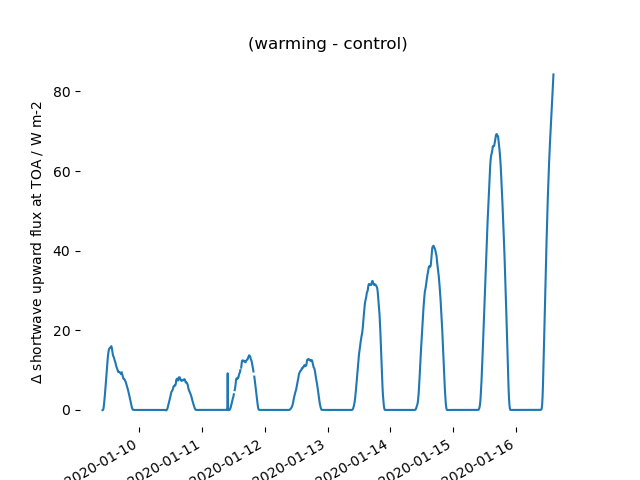

In [12]:
import IPython.display
def display_image(path): return IPython.display.Image(filename=path)
display_image('img/fixedfig_change_in_upward_shortwave_flux.png')

A daily 24h cyclicity is clearly visible in the signal. But also it reaches very high values at the end of the time series. This is coincide with high high cloud cover during that time frame. These high clouds are visible in both warming and control, but are much more pronounced in the warm simulation. 

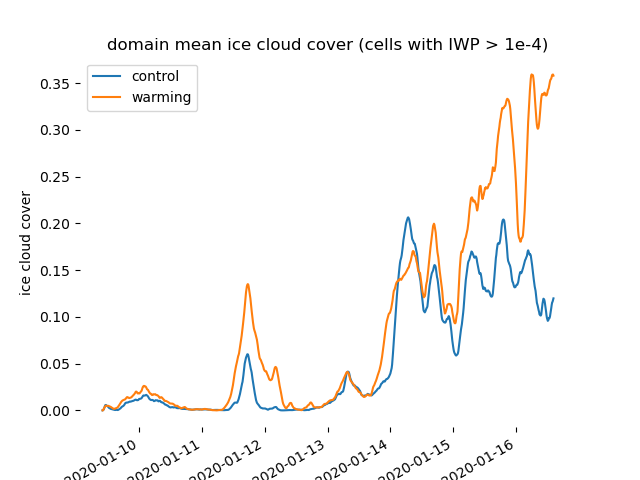

In [14]:
display_image('img/fixedfig_ice_cloud_cover.png')

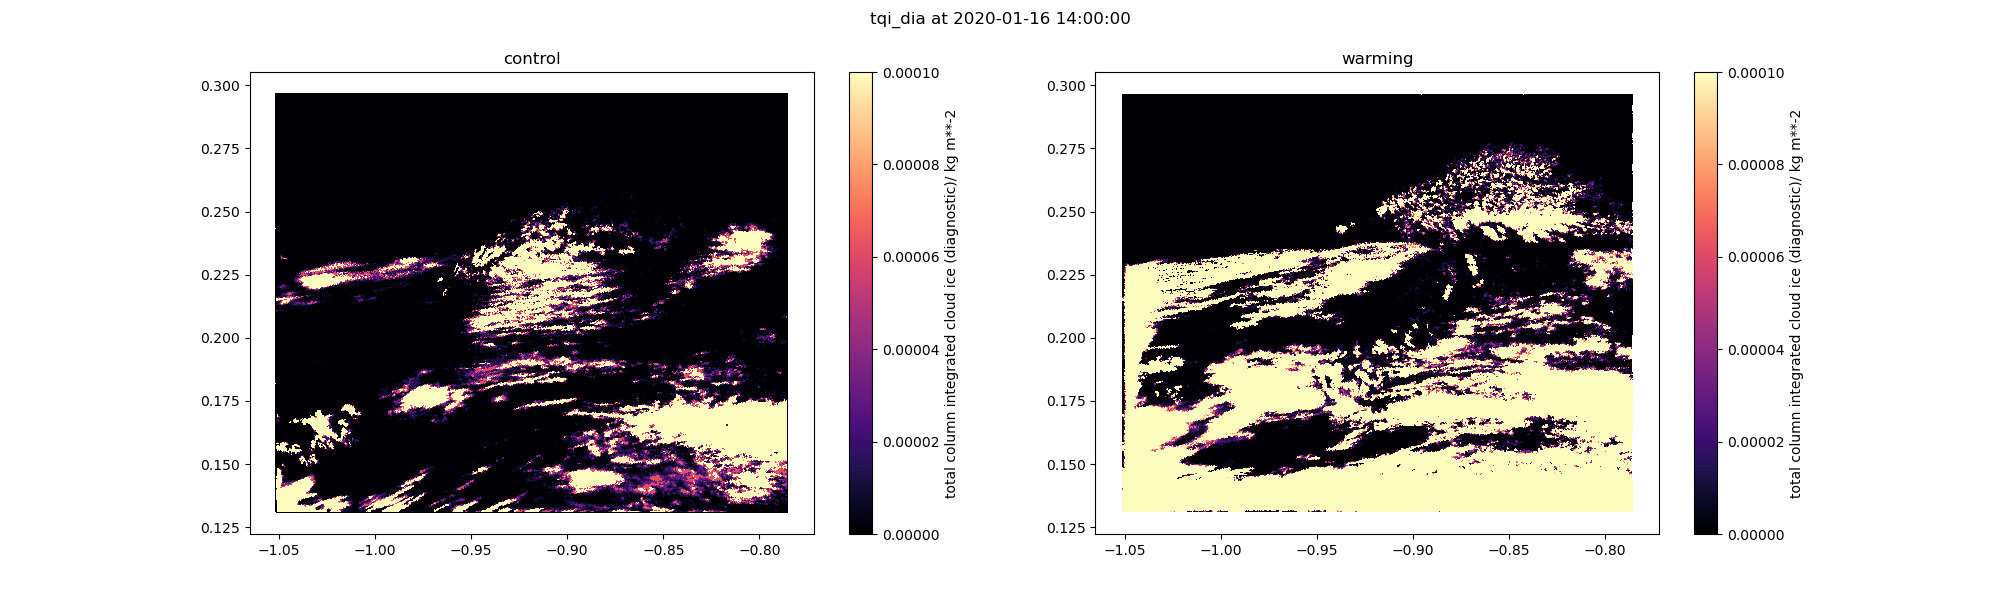

In [15]:
display_image('img/fig_icecloud_snapshot.png')

When we filter out cells with elevated ice content, this correlation is attenuated, but does not disappear. even if we lower the threshold (Filtering is done via the function `filter_by_threshold`, see below). 

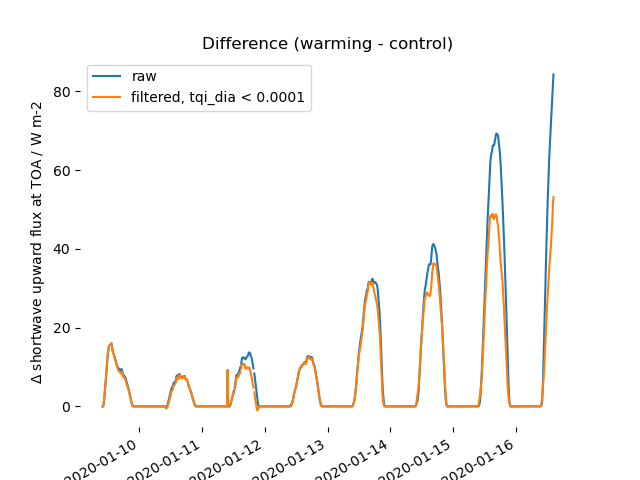

In [13]:
display_image('img/fixedfig_change_in_upward_shortwave_flux_filtered_highclouds.png')

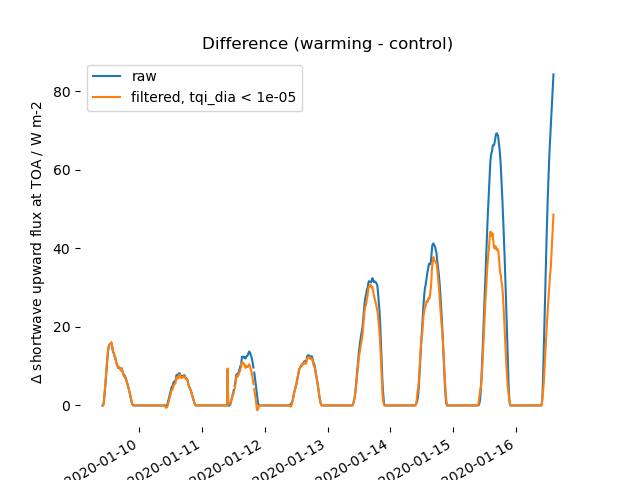

In [11]:
display_image('img/fig_change_in_upward_shortwave_flux_filtered_1e-5.png')

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    

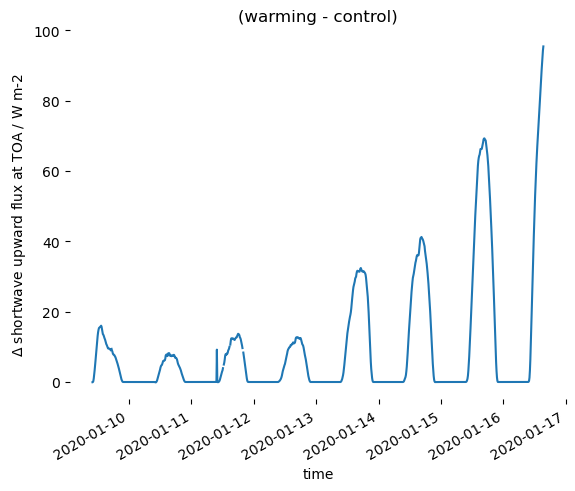

In [3]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import plot_utils as pu

def filter_common_vars(datasets):
    common_vars = set.intersection(*[set(ds.variables) for ds in datasets])
    return [ds[common_vars] for ds in datasets]

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.disk_data_from_keywords(exp_dir, [kind, 'DOM01'])
        data = pp.clean_surface_data(data)
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('warming',))
    data = add_control(data)
    # data = data.isel(time=slice(0,100)) #DB
    return data

def add_control(input_data):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, 'DOM01'])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

def fixedfig_change_in_upward_shortwave_flux():
    data = load_data()
    data = data.mean(dim='cell', keep_attrs=True)
    diff = data['sou_t'].sel(exp='warming')
    diff.values = diff.values - data['sou_t'].sel(exp='control').values
    diff = diff.where(diff.values < 100)
    
    fig, ax = plt.subplots()
    diff.plot(ax=ax, label='raw')
    ax.set_ylabel(f'$\Delta$ {diff.attrs["long_name"]} / {diff.attrs["units"]}')
    ax.set_title('(warming - control)')
    ax = pu.remove_spines(ax)
    return fig, ax

fig, ax = fixedfig_change_in_upward_shortwave_flux()
fig.savefig('img/fixedfig_change_in_upward_shortwave_flux.png')
fig.show()

/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(


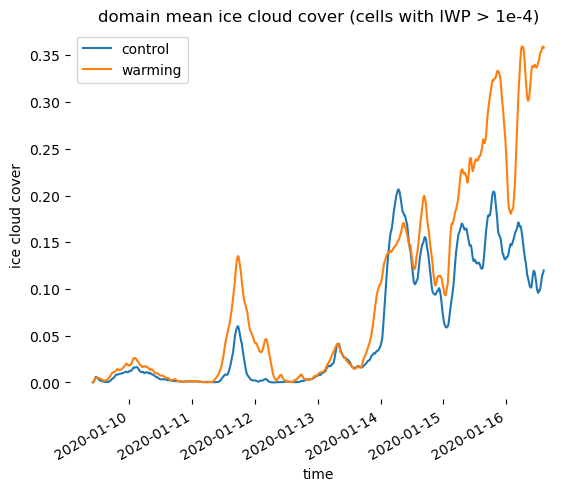

In [2]:
def add_threshold_indicator(dataset, variable_name, threshold, new_variable_name=None, long_name=None, boolean=True, below_threshold=False):
    """
    Add a threshold indicator variable to the dataset.

    This function adds a new threshold indicator variable to the input dataset,
    indicating whether the values of a specified variable exceed a given threshold.
    The indicator variable can be either boolean (True/False) or a float (1/0).

    Parameters:
    - dataset (xarray.Dataset): Input dataset to which the indicator variable will be added.
    - variable_name (str): Name of the variable in the dataset to evaluate against the threshold.
    - threshold (float): Threshold value for determining whether values exceed the threshold.
    - new_variable_name (str, optional): Name for the new indicator variable to be added
      to the dataset. If None, a default name will be generated based on the variable name
      and threshold. Default is None.
    - long_name (str, optional): Long name for the new indicator variable. If None, a default
      long name will be generated based on the variable name and threshold. Default is None.
    - boolean (bool, optional): If True, the indicator variable will be boolean (True/False).
      If False, the indicator variable will be a float with values of either 1 or 0. Default is True.
    - below_threshold (bool, optional): If True, the indicator variable be True where the values are 
      below the threshold. Default is False.

    Returns:
    - dataset_with_indicator (xarray.Dataset): Dataset with the new indicator variable added.
    """
    if new_variable_name is None: new_variable_name = f"{variable_name}>{threshold}"
    if long_name is None: long_name = new_variable_name

    indicator_variable = dataset[variable_name] > threshold
    if not boolean: indicator_variable = indicator_variable.astype('float32')
    if below_threshold: indicator_variable = not indicator_variable

    indicator_variable.attrs['long_name'] = long_name
    indicator_variable.attrs['units'] = ''
    dataset[new_variable_name] = indicator_variable
    return dataset

def add_icecloud_mask(dataset):
    return pp.add_threshold_indicator(dataset, variable_name='tqi_dia', threshold=1e-4, new_variable_name='high_tqi', long_name='ice cloud mask', boolean=False)

def fixedfig_ice_cloud_cover():
    data = load_data()
    data = add_icecloud_mask(data)
    data = data.mean(dim='cell', keep_attrs=True)
    fig, ax = plt.subplots()
    for exp in ['control', 'warming']:
        d = data.sel(exp=exp)
        d['high_tqi'].plot(ax=ax, label=exp)
    ax.set_title('domain mean ice cloud cover (cells with IWP > 1e-4)')
    ax.set_ylabel('ice cloud cover')
    ax.legend()
    ax = pu.remove_spines(ax)
    return fig, ax

fig, ax = fixedfig_ice_cloud_cover()
fig.savefig('img/fixedfig_ice_cloud_cover.png')
fig.show()

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    

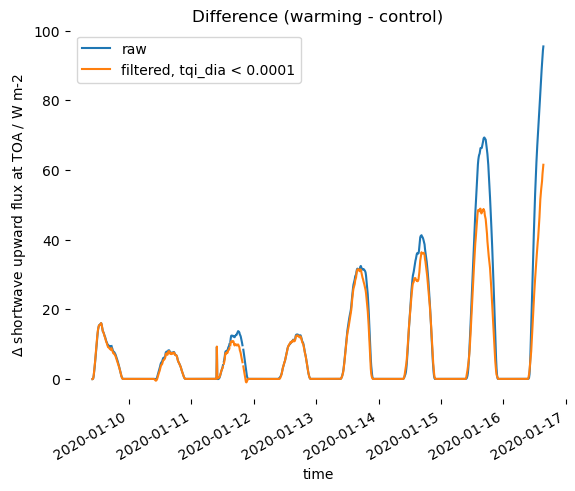

In [5]:
import numpy as np 
import plot_utils as pu

def filter_by_threshold(dataset, threshold_dict, below_threshold=True, chunk_size=None):
    """
    Filter dataset based on variable-specific thresholds.

    This function filters the input dataset based on variable-specific threshold values
    provided in the threshold_dict. For each variable specified in the threshold_dict,
    values exceeding the corresponding threshold are masked out.

    Parameters:
    - dataset (xarray.Dataset): Input dataset to be filtered.
    - threshold_dict (dict): Dictionary where keys are variable names and values are
      threshold values.
    - chunk_size (int or dict, optional): Chunk size to use for computation. If None,
      a heuristic is used to determine chunk size. Default is None.

    Returns:
    - filtered_dataset (xarray.Dataset): Filtered dataset with values exceeding the
      thresholds set to NaN.
    """
    mask = xr.ones_like(dataset, dtype=bool)
    for var_name, threshold in threshold_dict.items():
        if below_threshold:
            mask = mask & (dataset[var_name] < threshold)
        else:
            mask = mask & (dataset[var_name] > threshold)
    mask = mask.chunk(chunk_size)
    return dataset.where(mask)

def fig_change_in_upward_shortwave_flux_filtered_highclouds(threshold):
    fig, ax = fixedfig_change_in_upward_shortwave_flux()
    
    data = load_data()
    data = filter_by_threshold(data, {'tqi_dia':threshold})
    data = data.mean(dim='cell', keep_attrs=True)
    
    diff = data['sou_t'].sel(exp='warming')
    diff.values = diff.values - data['sou_t'].sel(exp='control').values
    diff = diff.where(diff.values < 100)
    diff.plot(ax=ax, label=f'filtered, tqi_dia < {threshold}')
    
    ax.set_ylabel(f'$\Delta$ {diff.attrs["long_name"]} / {diff.attrs["units"]}')
    ax.set_title('Difference (warming - control)')
    ax = pu.remove_spines(ax)
    ax.legend()
    return fig, ax

def fixedfig_change_in_upward_shortwave_flux_filtered_highclouds(threshold=1e-4):
    return fig_change_in_upward_shortwave_flux_filtered_highclouds(threshold)

fig, ax = fixedfig_change_in_upward_shortwave_flux_filtered_highclouds()
fig.savefig('img/fixedfig_change_in_upward_shortwave_flux_filtered_highclouds.png')
fig.show()

/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a p

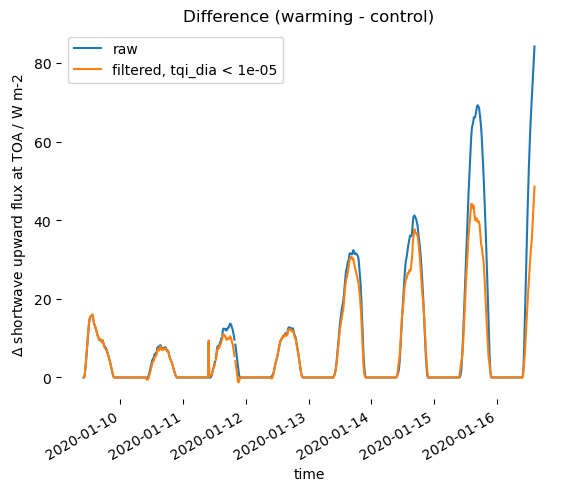

In [3]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import xarray as xr
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import plot_utils as pu

def filter_by_threshold(dataset, threshold_dict, chunk_size=None):
    """
    Filter dataset based on variable-specific thresholds.

    This function filters the input dataset based on variable-specific threshold values
    provided in the threshold_dict. For each variable specified in the threshold_dict,
    values exceeding the corresponding threshold are masked out.

    Parameters:
    - dataset (xarray.Dataset): Input dataset to be filtered.
    - threshold_dict (dict): Dictionary where keys are variable names and values are
      threshold values.
    - chunk_size (int or dict, optional): Chunk size to use for computation. If None,
      a heuristic is used to determine chunk size. Default is None.

    Returns:
    - filtered_dataset (xarray.Dataset): Filtered dataset with values exceeding the
      thresholds set to NaN.
    """
    mask = xr.ones_like(dataset, dtype=bool)
    for var_name, threshold in threshold_dict.items():
        mask = mask & (dataset[var_name] < threshold)
    mask = mask.chunk(chunk_size)
    return dataset.where(mask)


def filter_common_vars(datasets):
    common_vars = set.intersection(*[set(ds.variables) for ds in datasets])
    return [ds[common_vars] for ds in datasets]

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.disk_data_from_keywords(exp_dir, [kind])
        data = pp.clean_surface_data(data)
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('warming',))
    data = add_control(data)
    # data = data.isel(time=slice(0,100)) #DB
    return data

def add_control(input_data):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, 'DOM01'])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

def fixedfig_change_in_upward_shortwave_flux():
    data = load_data()
    data = data.mean(dim='cell', keep_attrs=True)
    diff = data['sou_t'].sel(exp='warming')
    diff.values = diff.values - data['sou_t'].sel(exp='control').values
    diff = diff.where(diff.values < 100)
    
    fig, ax = plt.subplots()
    diff.plot(ax=ax, label='raw')
    ax.set_ylabel(f'$\Delta$ {diff.attrs["long_name"]} / {diff.attrs["units"]}')
    ax.set_title('(warming - control)')
    ax = pu.remove_spines(ax)
    return fig, ax

def fig_change_in_upward_shortwave_flux_filtered_highclouds(threshold):
    fig, ax = fixedfig_change_in_upward_shortwave_flux()
    
    data = load_data()
    data = pp.filter_by_threshold(data, {'tqi_dia':threshold})
    data = data.mean(dim='cell', keep_attrs=True)
    
    diff = data['sou_t'].sel(exp='warming')
    diff.values = diff.values - data['sou_t'].sel(exp='control').values
    diff = diff.where(diff.values < 100)
    diff.plot(ax=ax, label=f'filtered, tqi_dia < {threshold}')
    
    ax.set_ylabel(f'$\Delta$ {diff.attrs["long_name"]} / {diff.attrs["units"]}')
    ax.set_title('Difference (warming - control)')
    ax = pu.remove_spines(ax)
    ax.legend()
    return fig, ax

fig, ax = fig_change_in_upward_shortwave_flux_filtered_highclouds(1e-5)
fig.show()

In [5]:
fig.savefig('img/fig_change_in_upward_shortwave_flux_filtered_1e-5.png')

/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(


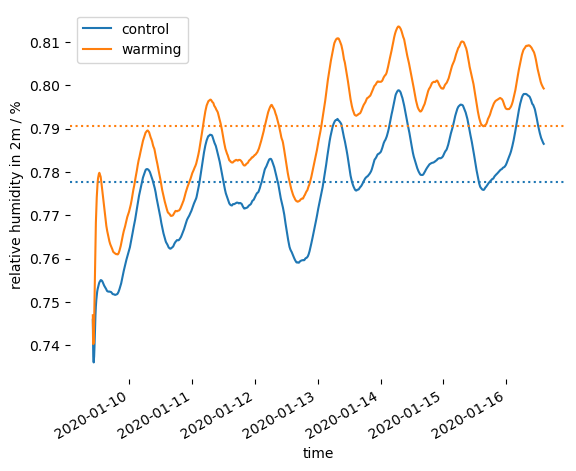

In [5]:
# Near surface RH vs time
def fig_timeseries(var='rh_2m'):
    fig, ax = plt.subplots()
    
    data = load_data()
    data = data.mean(dim='cell', keep_attrs=True)
    
    for exp, color in zip(['control', 'warming'], ['tab:blue', 'tab:orange']):
        data.sel(exp=exp)[var].plot(ax=ax, label=exp, color=color)
        ax.axhline(np.mean(data.sel(exp=exp)[var].values), color=color, ls=':')
        
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    ax.set_title('')
    ax = pu.remove_spines(ax)
    ax.legend()
    return fig, ax
                                
fig, ax = fig_timeseries('rh_2m')
# fig.savefig('img/fig_timeseries_rh_2m.png')
fig.show()

/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(


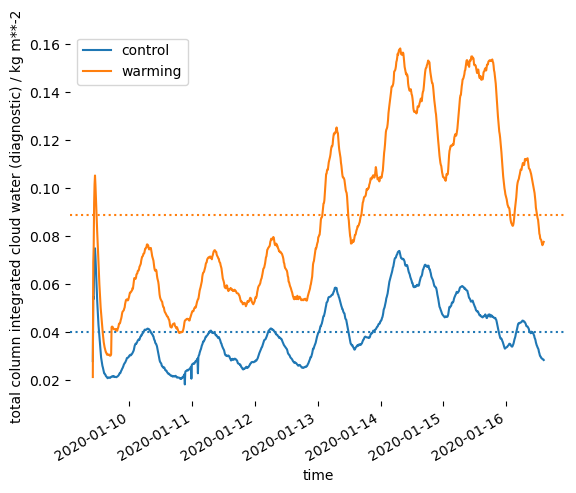

In [6]:
# cwv vs time
fig, ax = fig_timeseries('tqc_dia')
fig.savefig('img/fig_timeseries_tqc_dia.png')
fig.show()

/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(


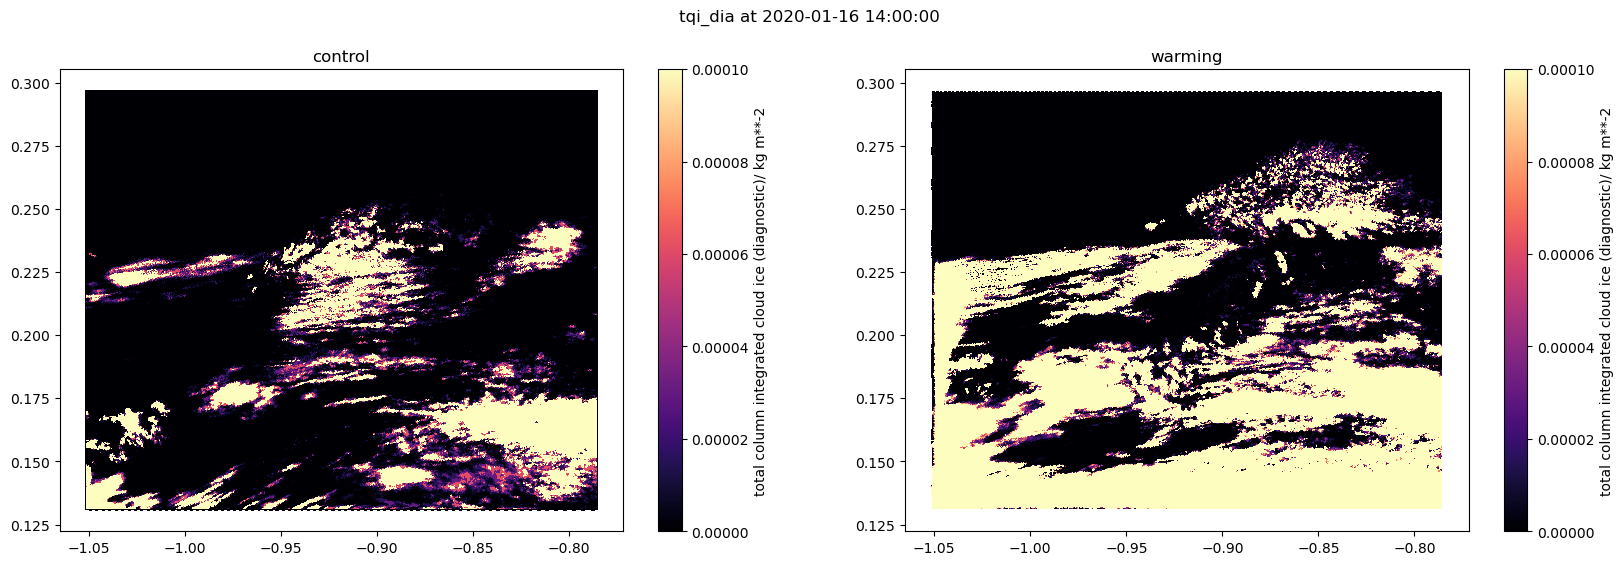

In [7]:
def get_eurec4a_data(domain='DOM01'):
    data = xr.open_zarr(f'https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/EUREC4A_LES/experiment_2/ICON_{domain}_surface.zarr')
    grid = xr.open_zarr(f'https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{domain}.zarr')
    return xr.merge([data,grid])

def load_data2(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
        datasets = list()
        for kind in ['surface', 'radiation']:
            data = fh.disk_data_from_keywords(exp_dir, [kind])
            data = pp.clean_surface_data(data)
            data = pp.add_grid(data, rad2deg=False, clean=False, drop_vars=False)
            datasets.append(data)
        datasets = pp.subset_time_overlap(datasets)
        data = xr.merge(datasets)
        return data

def fixedfig_icecloud_snapshot():
    time = pd.to_datetime('2020-01-16T14:00:00.000000000')
    figsize=(20,20*.3)

    fig, axs = plt.subplots(1,2, figsize=figsize)

    ax = axs[0]
    data = get_eurec4a_data().sel(time=time)
    ax = pu.ax_triangles(ax, data, 'tqi_dia', vminmax=(0,1e-4),cmap='magma')
    ax.set_title('control')

    ax = axs[1]
    data = load_data2().sel(time=time)
    ax = pu.ax_triangles(ax, data, 'tqi_dia', vminmax=(0,1e-4),cmap='magma')
    ax.set_title('warming')

    fig.suptitle(f'tqi_dia at {time}')
    return fig, axs

fig, ax = fixedfig_icecloud_snapshot()
fig.savefig('img/fig_icecloud_snapshot.png')
fig.show()

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import plot_utils as pu

def filter_common_vars(datasets):
    common_vars = set.intersection(*[set(ds.variables) for ds in datasets])
    return [ds[common_vars] for ds in datasets]

def load_data(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.disk_data_from_keywords(exp_dir, [kind, 'DOM01'])
        data = pp.clean_surface_data(data)
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('warming',))
    data = add_control(data)
    # data = data.isel(time=slice(0,100)) #DB
    return data

def add_control(input_data):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, 'DOM01'])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))

    datasets = [input_data, data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')

data = load_data()

/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(


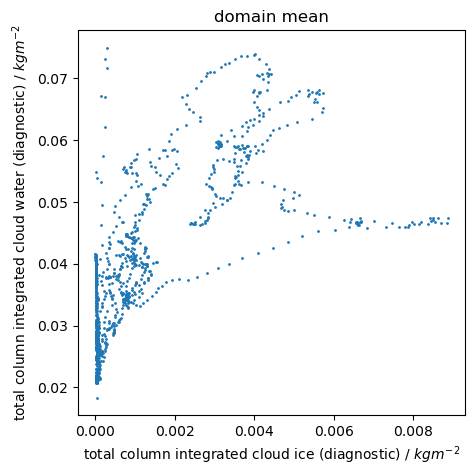

In [12]:
x = data['tqi_dia'].sel(exp='control').mean(dim='cell')#.values[::4**8]
y = data['tqc_dia'].sel(exp='control').mean(dim='cell')#.values[::4**8]

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x,y, s=1)
for varname, set_label in zip(['tqi_dia', 'tqc_dia'], [ax.set_xlabel, ax.set_ylabel]):
    set_label(f"{data[varname].attrs['long_name']} / {data[varname].attrs['units']}")
    set_label(f"{data[varname].attrs['long_name']} / $kg m^{{-2}}$")
ax.set_title('domain mean')
fig.show()

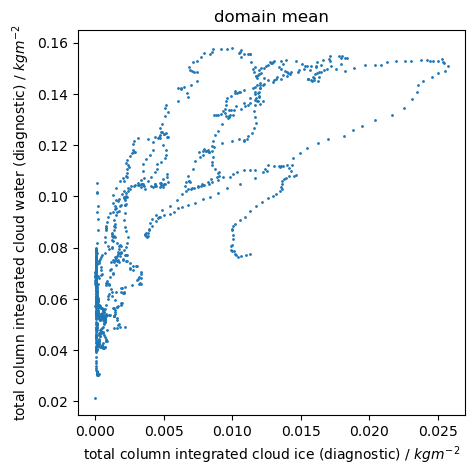

In [15]:
x = data['tqi_dia'].sel(exp='warming').mean(dim='cell')#.values[::4**8]
y = data['tqc_dia'].sel(exp='warming').mean(dim='cell')#.values[::4**8]

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x,y, s=1)
for varname, set_label in zip(['tqi_dia', 'tqc_dia'], [ax.set_xlabel, ax.set_ylabel]):
    set_label(f"{data[varname].attrs['long_name']} / {data[varname].attrs['units']}")
    set_label(f"{data[varname].attrs['long_name']} / $kg m^{{-2}}$")
ax.set_title('domain mean')
fig.show()

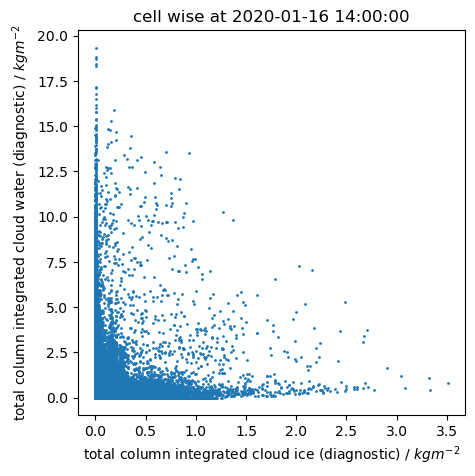

In [14]:
timestep = pd.to_datetime('2020-01-16T14:00:00.000000000')
x = data['tqi_dia'].sel(exp='warming', time=timestep)
y = data['tqc_dia'].sel(exp='warming', time=timestep)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x,y, s=1)
for varname, set_label in zip(['tqi_dia', 'tqc_dia'], [ax.set_xlabel, ax.set_ylabel]):
    set_label(f"{data[varname].attrs['long_name']} / {data[varname].attrs['units']}")
    set_label(f"{data[varname].attrs['long_name']} / $kg m^{{-2}}$")
ax.set_title(f'cell wise at {timestep}')
fig.show()

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import xarray as xr

def load_data(exp_dir='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/', keywords=['profile', 'domainmean']):
    datasets = list()
    for keyword in keywords:
        data = fh.disk_data_from_keywords(exp_dir, [keyword, 'DOM01'])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    return data

data = load_data()
data

/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(


<xarray.Dataset>
Dimensions:        (height: 136, height_2: 136, time: 169, bnds: 2)
Coordinates:
  * height         (height) float64 10.0 34.78 66.93 ... 5.481e+03 5.602e+03
  * height_2       (height_2) float64 10.0 34.78 66.93 ... 5.481e+03 5.602e+03
  * time           (time) datetime64[ns] 2020-01-09T10:00:00 ... 2020-01-16T1...
Dimensions without coordinates: bnds
Data variables: (12/29)
    height_bnds    (time, height, bnds) float64 dask.array<chunksize=(1, 136, 2), meta=np.ndarray>
    u              (time, height) float32 dask.array<chunksize=(1, 136), meta=np.ndarray>
    v              (time, height) float32 dask.array<chunksize=(1, 136), meta=np.ndarray>
    w              (time, height_2) float32 dask.array<chunksize=(1, 136), meta=np.ndarray>
    temp           (time, height) float32 dask.array<chunksize=(1, 136), meta=np.ndarray>
    pres           (time, height) float32 dask.array<chunksize=(1, 136), meta=np.ndarray>
    ...             ...
    clct           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    pres_sfc       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sou_t          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sob_t          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sod_t          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    thb_t          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

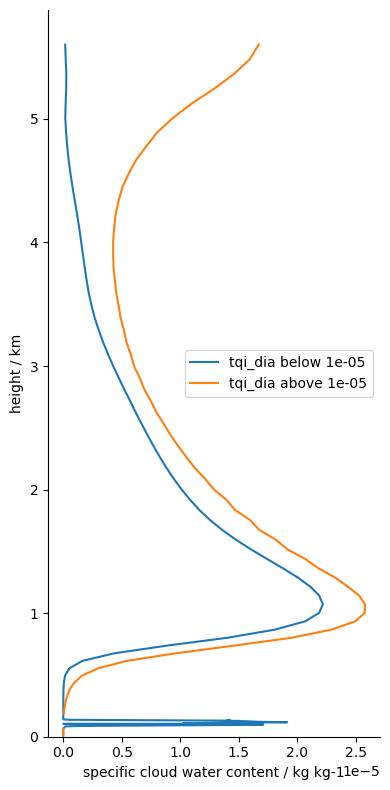

In [2]:
import matplotlib.pyplot as plt
import plot_utils as pu

fig, ax = plt.subplots(figsize=(4,8))
threshold_var = 'tqi_dia'
threshold = {'tqi_dia' : 1e-5}
d = pp.filter_by_threshold(data, threshold, True ).mean(dim='time', keep_attrs=True)
ax = pu.ax_profile(ax, d, 'qc', label=f'{list(threshold.keys())[0]} below {list(threshold.values())[0]}')
d = pp.filter_by_threshold(data, threshold, False).mean(dim='time', keep_attrs=True)
ax = pu.ax_profile(ax, d, 'qc', label=f'{list(threshold.keys())[0]} above {list(threshold.values())[0]}')
ax.legend()
fig.tight_layout()
fig.show()